In [3]:
from collections import Counter
from tqdm import tqdm
import cgranges
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
import cgranges as cr
g = cr.cgranges()
g.add("chr1", 10, 20, 0)
g.add("chr1", 15, 25, 1)
g.add("chr1", 20    , 25, 2)
g.index()
for st, en, label in g.overlap("chr1", 12, 16):
        print(st, en, label)


10 20 0
15 25 1


In [4]:
class Isoform:
    def __init__(self, tid, chrom, strand):
        self.tid = tid
        self.chrom = chrom
        self.strand = strand
        self.exons = list()
    def build_introns(self):
        self.introns = tuple(
            (e1+1, s2-1)
            for (_,e1),(s2,_) in zip(self.exons[:-1], self.exons[1:])
        )
    def build_intron_str(self):
        self.introns_str = ":".join([f"{x[0]}-{x[1]}" for x in self.introns])

In [5]:
def get_isoforms(in_gtf):
    bad_tids = set()
    isoforms = list()
    tid_to_idx = dict()
    for line in tqdm(open(in_gtf), desc=f"Reading {in_gtf}"):
        if line.startswith('#'):
            continue
        line = line.strip().split('\t')
        if line[2] != 'exon':
            continue

        info = line[8]
        info = [x.strip().split(' ') for x in info.strip(';').split(';')]
        info = {x[0]:x[1].strip('"') for x in info}

        tid = info['transcript_id']
        if tid not in tid_to_idx:
            tid_to_idx[tid] = len(isoforms)
            isoforms.append(Isoform(
                tid=tid,
                chrom=line[0],
                strand=line[6],
            ))
        idx = tid_to_idx[tid]
        start, end = int(line[3]) - 1, int(line[4])
        if end - start < 1:
            bad_tids.add(tid)
        isoforms[idx].exons.append((start, end))
    for isoform in isoforms:
        isoform.exons = tuple(sorted(isoform.exons))
        isoform.build_introns()
        isoform.build_intron_str()
    print(f"Found {len(bad_tids)} transcripts with bad coordinates")
    print(bad_tids)
    isoforms = [x for x in isoforms if x.tid not in bad_tids]
    tid_to_idx = {x.tid:i for i,x in enumerate(isoforms)}
    return tid_to_idx,isoforms

In [6]:
in_gtf = "output/results/S1/freddie.isoforms.gtf"
annot_gtf = "data/refs/homo_sapiens.annot.gtf"
in_tid_to_idx,in_isoforms = get_isoforms(in_gtf)
annot_tid_to_idx,annot_isoforms = get_isoforms(annot_gtf)

Reading output/results/S1/freddie.isoforms.gtf: 242245it [00:01, 186303.88it/s]


Found 4 transcripts with bad coordinates
{'2_49_0', '2_220_4', '2_220_3', '15_250_0'}


Reading data/refs/homo_sapiens.annot.gtf: 3408735it [00:28, 118911.09it/s]


Found 0 transcripts with bad coordinates
set()


In [16]:
intron_lens = dict()
for isoform in tqdm(annot_isoforms):
    for idx,(s,e) in enumerate(isoform.introns):
        intron_lens[(isoform.tid,idx)] = (e-s)
intron_lens = pd.DataFrame.from_dict(intron_lens, orient='index', columns=['intron_len'])   

  0%|          | 0/252242 [00:00<?, ?it/s]

100%|██████████| 252242/252242 [00:01<00:00, 134855.08it/s]


array([[<Axes: title={'center': 'intron_len'}>]], dtype=object)

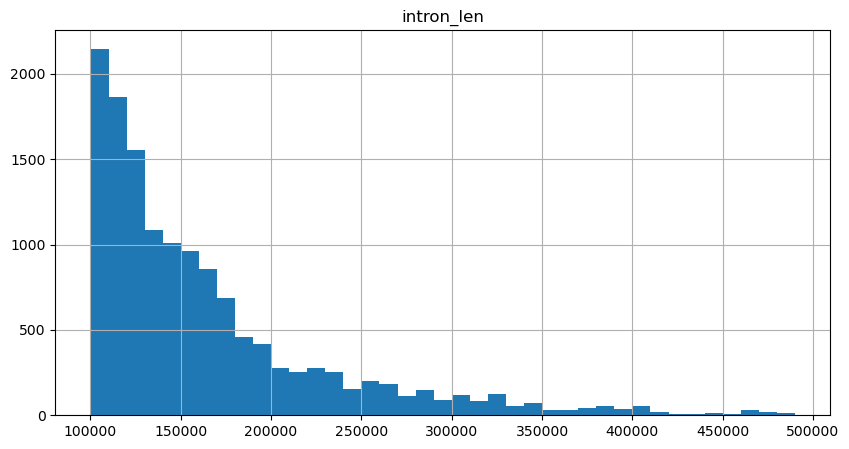

In [29]:

import numpy as np


intron_lens.hist(bins=np.arange(1e5,5e5,1e4), figsize=(10, 5))
# print(sum(intron_lens.intron_len > 2e5))

In [6]:
def get_index(isoforms):
    I = cgranges.cgranges()
    for idx, isoform in tqdm(enumerate(isoforms), total=len(isoforms)):
        for s,e in isoform.exons:
            I.add(isoform.chrom, s, e, idx)
    I.index()
    return I

In [7]:

def get_canonical_intervals(interval_lists, min_length=0):
    result = list()
    breakpoints = set()
    g = cgranges.cgranges()
    for idx, genomic_interval_list in enumerate(interval_lists):
        for start, end in genomic_interval_list:
            g.add("", start, end, idx)
            breakpoints.add(start)
            breakpoints.add(end)
    g.index()
    breakpoints = sorted(breakpoints)
    for s,e in zip(breakpoints[:-1], breakpoints[1:]):
        if e - s < min_length:
            continue
        labels = set((l for _,_,l in g.overlap("", s, e)))
        labels = tuple(idx in labels for idx in range(len(interval_lists)))
        if any(labels):
            result.append((s, e, labels))
    return result

In [8]:
def charecterize_intervals(c_intervals):
    i = j = -1
    for i,(_,_,labels) in enumerate(c_intervals):
        if all(labels):
            break
    for j,(_,_,labels) in enumerate(c_intervals[::-1]):
        if all(labels):
            break
    assert i != -1, c_intervals
    j = len(c_intervals) - j - 1

    counter = Counter()
    for idx, (_,_,labels) in enumerate(c_intervals):
        if idx < i:
            key = -1 # Prefix
        elif idx > j: 
            key = +1 # Suffix
        else:
            key = 0 # Main
        counter[(key, *labels)] += 1
    return counter


In [9]:
annot_exon_index = get_index(annot_isoforms)
in_exon_index = get_index(in_isoforms)

  7%|▋         | 17013/252242 [00:00<00:01, 170112.32it/s]

100%|██████████| 43596/43596 [00:00<00:00, 491926.21it/s]


In [10]:
fields = [
    "in_iso",
    "annot_iso",
    "in_exons",
    "annot_exons",
    "in_c_exons",
    "annot_c_exons",
    "prefix_m",
    "prefix_i",
    "prefix_d",
    "main_m",
    "main_i",
    "main_d",
    "suffix_m",
    "suffix_i",
    "suffix_d",
]
prefix_key = -1
main_key = 0
suffix_key = +1
match_key = (True, True)
insertion_key = (False, True)
deletion_key = (True, False)
match_fields_keys = [
    (k1, *k2)
    for k1 in (prefix_key, main_key, suffix_key)
    for k2 in (match_key, insertion_key, deletion_key)
]
X = 0
with open("isoform-matches.csv", "w+") as outfile:
    record = list()
    for f in fields:
        record.append(f"{f}")
    print(",".join(record), file=outfile)
    i_isoforms_tids = set()
    a_isoforms_tids = set()
    for i_isoform in tqdm(in_isoforms):
        a_idxs = {
            a_idx
            for s,e in i_isoform.exons
            for _,_,a_idx in annot_exon_index.overlap(i_isoform.chrom, s, e)
        }
        for a_idx in a_idxs:
            record = [
                f"{i_isoform.tid}",
                f"{annot_isoforms[a_idx].tid}",
                f"{len(i_isoform.exons)}",
                f"{len(annot_isoforms[a_idx].exons)}",
            ]       

            c_intervals = get_canonical_intervals(
                (
                    annot_isoforms[a_idx].exons,
                    i_isoform.exons,
                ),
                min_length=10
            )
            matches = charecterize_intervals(c_intervals)
            record.extend([
                f"{sum(v for k,v in matches.items() if k[2])}", # Canonical intervals with input isoform
                f"{sum(v for k,v in matches.items() if k[1])}", # Canonical intervals with annot isoform
            ])
            i_isoforms_tids.add(i_isoform.tid)
            a_isoforms_tids.add(annot_isoforms[a_idx].tid)
            for key in match_fields_keys:
                record.append(f"{matches[key]}")
            print(",".join(record), file=outfile)
            X += 1


  1%|▏         | 650/43596 [00:00<00:40, 1072.13it/s]

100%|██████████| 43596/43596 [00:35<00:00, 1232.68it/s]


In [11]:
X

445932

In [12]:
A = pd.read_csv("isoform-matches.csv")

In [13]:
B = pd.read_csv("output/simulate/TS/S1.tsv", sep='\t')

In [198]:
min_coverage = 5
tid_to_counts = B.transcript_id.value_counts()
multi_exon_annot_tids = {
    tid for tid in annot_tid_to_idx.keys()
    if len(annot_isoforms[annot_tid_to_idx[tid]].exons) > 1
}
simulated_tids = tid_to_counts[(tid_to_counts > min_coverage) & (tid_to_counts.index.isin(multi_exon_annot_tids))]

In [199]:
def plot_coverage(simulated_tids, detected_tids, title, reverse_sort=False):
    if reverse_sort:
        simulated_tids = reversed(list(simulated_tids.items()))
    else:
        simulated_tids = list(simulated_tids.items())
    coverage = list()
    detection = list()
    detection_rate = list()
    detected_count = 0

    for tid, count in simulated_tids:
        coverage.append(count)
        detected_count += tid in detected_tids
        detection.append(detected_count)
        detection_rate.append(detected_count/len(detection))

    fig, axes = plt.subplots(2,1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(title)
    ax = axes[0]
    ax.plot(coverage, color="C0", label='# of reads simulated')
    # ax.set_yscale('log')
    ax.grid(axis='y', linestyle='-')
    # lim y axis
    ax.set_ylim(1, 5e2)
    ax2 = ax.twinx()
    ax2.plot(
        [0, len(coverage)],
        [0, len(coverage)],
        linestyle="--",
        color='C1',
        label=f"# of simulated isoforms ({'reverse ' if reverse_sort else ''}sorted by coverage)"
    )
    ax2.plot(
        detection,
        color="C2",
        label='# of simulated isoforms detected by Freddie'
    )
    ax2.grid(axis='y', linestyle='--')

    axes[1].plot(
        detection_rate,
        color="C3",
        label="Detection rate",
    )
    # Percent formatter
    axes[1].yaxis.set_major_formatter(lambda x, pos: f"{x*100:.0f}%")
    axes[1].set_ylim(0,1)
    axes[1].set_yticks([.2,.4,.6,.8,1])
    axes[1].grid(axis='y', linestyle='--')
    axes[1].yaxis.tick_right()

    # Legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = axes[1].get_legend_handles_labels()
    ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper center', framealpha=1)
    plt.show()

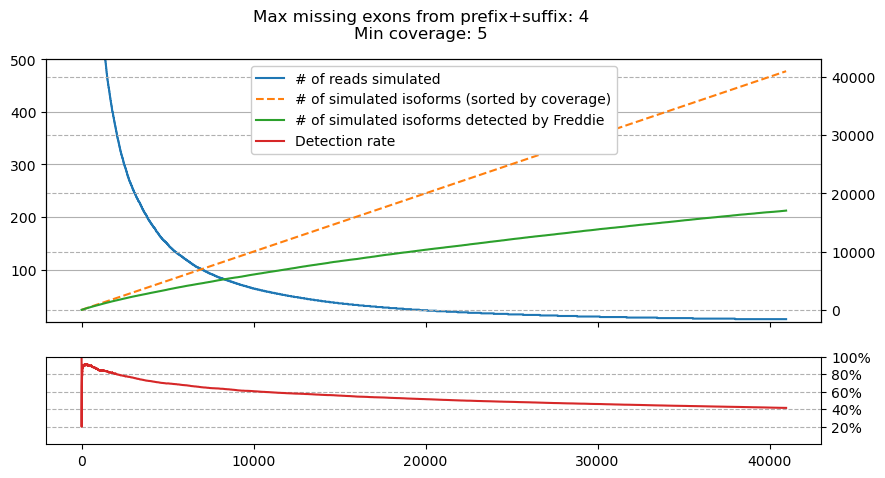

In [204]:
for max_missing in range(4,5):
    detected_tids = set(A[
        (A.prefix_d * A.prefix_i == 0) & # one is the suffix of the other
        (A.suffix_d * A.suffix_i == 0) & # one is the prefix of the other
        (A.prefix_d + A.prefix_i <= 2) & # the one with longer head can have at most one extra exon(s)
        (A.suffix_d + A.suffix_i <= 2) & # the one with longer tail can have at most one extra exon(s)
        (A.prefix_d + A.prefix_i + A.suffix_d + A.suffix_i <= max_missing) & # total extra exons can be at most max_missing
        (A.main_d + A.main_i == 0) & # no extra exons in the middle
        (A.main_m >= 1) # at least one match in the middle
    ].annot_iso)
    plot_coverage(simulated_tids, detected_tids, reverse_sort=False, title=f"Max missing exons from prefix+suffix: {max_missing}\nMin coverage: {min_coverage}")

In [201]:
for tid, read_count in tid_to_counts.items():
    if read_count < 10 or read_count > 100:
        continue
    exon_count = len(annot_isoforms[annot_tid_to_idx[tid]].exons)
    if exon_count < 2:
        continue
    if tid in detected_tids:
        continue
    print(tid, read_count, exon_count)
    break

ENST00000678110 100 11


In [202]:
annot_isoforms[annot_tid_to_idx[tid]].exons

((64498256, 64500326),
 (64500548, 64502069),
 (64502161, 64502223),
 (64502438, 64502549),
 (64502925, 64503098),
 (64503187, 64503348),
 (64503429, 64503868),
 (64503982, 64504116),
 (64504221, 64504318),
 (64504676, 64504842),
 (64506075, 64506349))

In [203]:
get_canonical_intervals(
    [
        in_isoforms[in_tid_to_idx['17_680_3']].exons,
        annot_isoforms[annot_tid_to_idx['ENST00000678110']].exons,
    ],
    # 115,
)

[(64498256, 64500326, (False, True)),
 (64500548, 64502069, (False, True)),
 (64502160, 64502161, (True, False)),
 (64502161, 64502223, (True, True)),
 (64502437, 64502438, (True, False)),
 (64502438, 64502549, (True, True)),
 (64502924, 64502925, (True, False)),
 (64502925, 64503098, (True, True)),
 (64503186, 64503187, (True, False)),
 (64503187, 64503348, (True, True)),
 (64503425, 64503429, (True, False)),
 (64503429, 64503868, (True, True)),
 (64503981, 64503982, (True, False)),
 (64503982, 64504116, (True, True)),
 (64504220, 64504221, (True, False)),
 (64504221, 64504318, (True, True)),
 (64504675, 64504676, (True, False)),
 (64504676, 64504842, (True, True)),
 (64506074, 64506075, (True, False)),
 (64506075, 64506261, (True, True)),
 (64506261, 64506349, (False, True)),
 (64506512, 64506732, (True, False))]